# Collaborative Filtering

Kolaborativno filtriranje je tehnika kojom se ocjene filmova predvidjaju na osnovu slicnosti medju korisnicima, odnosno medju filmovima. Preporucuju se oni filmovi za koje je predvidjena ocjena najvisa.

U slucaju problema $cold$ $start$ sistemi zastovani na sadrzaju ($content-based$) su korisni, kao i kada informacije o korisnicima i proizvodima nisu dostupne. Medjutim, u poredjenju sa njima, CF pristup je siri i fleksibilniji za identifikaciju slicnih proizvoda.

In [0]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
%matplotlib inline

import warnings; warnings.simplefilter('ignore')

In [2]:
from google.colab import files
import io
uploaded = files.upload()

Saving ratings.csv to ratings (1).csv


In [3]:
rating_df=pd.read_csv(io.BytesIO(uploaded['ratings.csv']))
rating_df.shape

(100836, 4)

In [4]:
rating_df=rating_df.sort_values('movieId')
rating_df=rating_df.reset_index()
rating_df.head()

,index,userId,movieId,rating,timestamp
0,0,1,1,4.0,964982703
1,81531,517,1,4.0,1487954343
2,30517,213,1,3.5,1316196157
3,81082,514,1,4.0,1533872400
4,30601,214,1,3.0,853937855


In [0]:
all_id=rating_df['movieId'].unique()

In [6]:
all_id[1150:1170] # filmovima nisu dodjeljeni Id brojevi redom, neki Id nedostaju 

array([1514, 1515, 1516, 1517, 1518, 1519, 1526, 1527, 1529, 1533, 1537,
       1541, 1542, 1544, 1545, 1546, 1547, 1549, 1550, 1551])

In [0]:
last_ind=rating_df.index[rating_df['movieId']==1500][-1]

In [8]:
rating_df=rating_df[:last_ind] # poslednji movieId 1500
rating_df.shape

(32236, 5)

In [9]:
n_users = rating_df.userId.unique().shape[0]
n_movies = rating_df.movieId.unique().shape[0] # broj filmova kojima je za Id dodjeljen neki broj <=1500 
print ('Ukupno: ' + str(n_users) + ' korisnika, ' + str(n_movies) + ' filma')

Ukupno: 608 korisnika, 1146 filma


In [10]:
uploaded2 = files.upload()

Saving movies.csv to movies (1).csv


In [11]:
movies_df=pd.read_csv(io.BytesIO(uploaded2['movies.csv']))
movies_df.shape

(9742, 3)

In [12]:
movies_df=movies_df.sort_values('movieId')
movies_df=movies_df.reset_index()
movies_df.head()

,index,movieId,title,genres
0,0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,2,Jumanji (1995),Adventure|Children|Fantasy
2,2,3,Grumpier Old Men (1995),Comedy|Romance
3,3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,4,5,Father of the Bride Part II (1995),Comedy


In [0]:
last_ind_in_movies_df=movies_df.index[movies_df['movieId']==1500][-1]

In [0]:
movies_df=movies_df[:last_ind_in_movies_df+1]

In [15]:
ocjene=np.linspace(rating_df.rating.min(), rating_df.rating.max(), 10)
print('Ocjene filmova:')
for o in ocjene: # moguce ocjene su 0.5, 1, 1.5, ..., 5
    print(o)

Ocjene filmova:
0.5
1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5
5.0


In [0]:
df_pivot=rating_df.pivot_table(values='rating', index='userId', columns='movieId').fillna(0)

In [0]:
ratings=df_pivot.as_matrix()

In [18]:
ratings # matrica koja sadrzi ocjene koje je i. korisnik dao j. filmu
# 0 ako korisnik nije ocjenio film

array([[4. , 0. , 4. , ..., 0. , 0. , 4. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [2.5, 2. , 2. , ..., 0. , 3. , 4. ],
       [3. , 0. , 0. , ..., 0. , 0. , 0. ],
       [5. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [19]:
ratings.shape

(608, 1146)

In [0]:
def sparsity(ratings): # prorjedjenost matrice
    sparsity = float(len(ratings.nonzero()[0]))
    sparsity /= (ratings.shape[0] * ratings.shape[1])
    sparsity *= 100
    return 100-sparsity

In [21]:
sparsity(ratings)

95.37349591255627

In [22]:
print ('Sparsity: {}%'.format(round(sparsity(ratings), 2)))

Sparsity: 95.37%


### Podjela na skup za obucavanje i testiranje

In [0]:
def my_train_test_split(ratings, test_size): # skupovi za obucavanje i testiranje su istog oblika, ali su vrijednsti 
    # raspodijeljene: test_size ocjena ce biti u skupu za testiranje
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    rows = (ratings != 0).sum(1)
    
    for user in range(ratings.shape[0]):
        count_per_user=int(np.ceil(test_size*rows[user]))
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], # 0 jer je nonzero primjenjeno na vektor
                                        size=count_per_user,  # indexi na kojima nisu 0
                                        replace=False)
        # u skup za obucavanje se upisuju 0 na izabranim pozicijama, a u skup za testiranje se upisuju elementi 
        train[user, test_ratings] = 0
        test[user, test_ratings] = ratings[user, test_ratings] 
        
    # provjera da li su poznate ocjene ili u jednom ili u drugom skupu
    assert(np.all((train * test) == 0)) 
    return train, test

In [0]:
train, test = my_train_test_split(ratings, 0.2)

In [25]:
sparsity(train)

96.33436093506016

In [26]:
train.shape # skupovi za obucavanje i testiranje su istih dimenzija, s tim sto im je proredjenost drugacija

(608, 1146)

In [27]:
test.shape

(608, 1146)

In [28]:
sparsity(test)

99.03913497749609

# Item-based Collaborative Filtering

In [0]:
def movies_similarity(ratings, epsilon=1e-9):
    # dodaje se epsilon -> mala vrijednost u slucaju da je slicnost filmova 0
    return cosine_similarity(ratings.T)+epsilon

In [0]:
m_sim=movies_similarity(train)

In [0]:
def predict_movies_top_k(ratings, movies_similarity, k=10):
    pred = np.zeros(ratings.shape)
    for j in range(ratings.shape[1]):
        top_k_items=[np.argsort(movies_similarity)[j][::-1][1:k+1]]
       
        for i in range(ratings.shape[0]):
            pred[i, j] = movies_similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
            pred[i, j] /= np.sum(np.abs(movies_similarity[j, :][top_k_items]))        
    
    return pred

In [0]:
m_pred=predict_movies_top_k(train, m_sim)

# User-based Collaborative Filtering

In [0]:
def users_similarity(ratings, epsilon=1e-9):
    return cosine_similarity(ratings)+epsilon

In [34]:
u_sim=users_similarity(train)
u_sim.shape

(608, 608)

In [0]:
def predict_users_top_k(ratings, users_similarity, k=10):
    pred = np.zeros(ratings.shape)

    for i in range(ratings.shape[0]):
        top_k_users=[np.argsort(users_similarity[:,i])[::-1][1:k]]
        #print(top_k_users)
        for j in range(ratings.shape[1]):
            pred[i,j]=ratings[:, j][top_k_users].mean()
    
    return pred

In [0]:
u_pred=predict_users_top_k(train, u_sim)

### Validacija

In [0]:
def get_rmse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return np.sqrt(mean_squared_error(pred, actual))

In [0]:
def get_mae(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_absolute_error(pred, actual)

In [39]:
print ('Item-based CF RMSE train: {}'.format(get_rmse(m_pred, train)))
print ('Item-based CF RMSE test: {}'.format(get_rmse(m_pred, test)))

print ('Item-based CF MAE train: {}'.format(get_mae(m_pred, train)))
print ('Item-based CF MAE test: {}'.format(get_mae(m_pred, test)))

Item-based CF RMSE train: 2.340159854906218
Item-based CF RMSE test: 2.7096632770423135
Item-based CF MAE train: 2.030070514546134
Item-based CF MAE test: 2.4051908753604407


In [40]:
print ('User-based CF RMSE train: {}'.format(get_rmse(u_pred, train)))
print ('User-based CF RMSE test: {}'.format(get_rmse(u_pred, test)))

print ('User-based CF MAE train: {}'.format(get_mae(u_pred, train)))
print ('User-based CF MAE test: {}'.format(get_mae(u_pred, test)))

User-based CF RMSE train: 2.4288528888028456
User-based CF RMSE test: 2.7205228743722363
User-based CF MAE train: 2.118895979884195
User-based CF MAE test: 2.431798191021492


### Izbor vrijednosti za $k$ najblizih susjeda

In [0]:
k_array = [10, 20, 50, 100]

u_train_mae = []
u_test_mae = []
m_test_mae = []
m_train_mae = []

for k in k_array:
    u_pred = predict_users_top_k(train, u_sim, k=k)
    m_pred = predict_movies_top_k(train, m_sim, k=k)
    
    u_train_mae += [get_mae(u_pred, train)]
    u_test_mae += [get_mae(u_pred, test)]
    
    m_train_mae += [get_mae(m_pred, train)]
    m_test_mae += [get_mae(m_pred, test)] 

Text(0, 0.5, 'MSE')

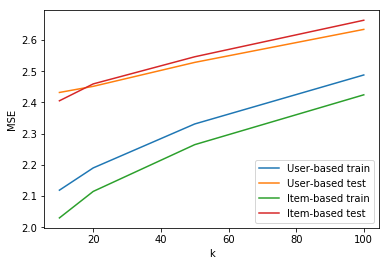

In [42]:
plt.plot(k_array, u_train_mae, label='User-based train')
plt.plot(k_array, u_test_mae, label='User-based test')
plt.plot(k_array, m_train_mae, label='Item-based train')
plt.plot(k_array, m_test_mae, label='Item-based test')
plt.legend(loc='best')
plt.xlabel('k')
plt.ylabel('MSE')

# Singular Value Decomposition

In [0]:
U, sigma, Vt = svds(train, k = 3) # k singularnih vrijednosti i vektora
sigma=np.diag(sigma)

### Predvidjanje ocjena na osnovu dekomponovane matrice

In [0]:
predicted_ratings = np.dot(np.dot(U, sigma), Vt)

In [45]:
print ('SVD CF MAE train: {}'.format(get_mae(predicted_ratings, train)))
print ('SVD CF MAE test: {}'.format(get_mae(predicted_ratings, test)))

SVD CF MAE train: 2.536757268271119
SVD CF MAE test: 2.632904925708375


In [0]:
k_array = [1, 3, 5] # broj singularnih vrijednosti i vektora

train_mae = []
test_mae = []

for k in k_array:
    
    U, sigma, Vt = svds(train, k = k)
    sigma=np.diag(sigma)
    
    all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)
    
    train_mae += [get_mae(all_user_predicted_ratings, train)]
    test_mae += [get_mae(all_user_predicted_ratings, test)]


Text(0, 0.5, 'MSE')

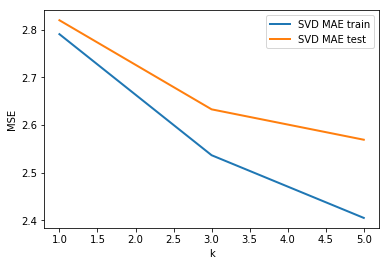

In [47]:
plt.plot(k_array, train_mae, label='SVD MAE train', linewidth=2)
plt.plot(k_array, test_mae, label='SVD MAE test', linewidth=2)
plt.legend(loc='best', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('k', fontsize=10)
plt.ylabel('MSE', fontsize=10)

### Preporuka filmova

In [48]:
preds_df = pd.DataFrame(predicted_ratings, columns = df_pivot.columns)
preds_df.shape

(608, 1146)

In [0]:
def recommend_movies(predictions_df, userId, movies_df, original_ratings_df, num_recommendations=5):
    
    # sortiranje predvidjenih ocjena filmova 
    user_row_number = userId - 1 # indeksiranje userId pocinje od 1
    sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False) # UserID starts at 1
    
    # uzimanje podataka o korisniku iz polazne podataka
    user_data = original_ratings_df[original_ratings_df.userId == (userId)]
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False))

    print ('Broj filmova koje je korisnik {0} vec ocjenio: {1}'.format(userId, user_full.shape[0]))
    print ('Broj neocjenjenih filmova za koje su predvidjene najvise ocjene: {0}'.format(num_recommendations))
    
    # preporuka neocjenjenih filmova za koje su predvidjene najvise ocjene
    recommendations = (movies_df[~movies_df['movieId'].isin(user_full['movieId'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movieId',
               right_on = 'movieId').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

In [50]:
already_rated, predictions = recommend_movies(preds_df, 1, movies_df, rating_df, 5)

Broj filmova koje je korisnik 1 vec ocjenio: 98
Broj neocjenjenih filmova za koje su predvidjene najvise ocjene: 5


In [51]:
already_rated.head()

,index_x,userId,movieId,rating,timestamp,index_y,title,genres
61,61,1,1080,5.0,964981327,820,Monty Python's Life of Brian (1979),Comedy
53,53,1,1029,5.0,964982855,786,Dumbo (1941),Animation|Children|Drama|Musical
28,28,1,527,5.0,964984002,461,Schindler's List (1993),Drama|War
77,77,1,1220,5.0,964981909,921,"Blues Brothers, The (1980)",Action|Comedy|Musical
60,60,1,1073,5.0,964981680,815,Willy Wonka & the Chocolate Factory (1971),Children|Comedy|Fantasy|Musical


In [52]:
predictions

,index,movieId,title,genres
259,277,318,"Shawshank Redemption, The (1994)",Crime|Drama
615,659,858,"Godfather, The (1972)",Crime|Drama
475,507,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi
844,922,1221,"Godfather: Part II, The (1974)",Crime|Drama
736,793,1036,Die Hard (1988),Action|Crime|Thriller


# Implementacija metoda Stohasticki gradijentni spust

Metod latentnih faktora za CF, koji se moze sprovesti pomocu stohastickog gradijentnog spusta, koristi postojece ocjene filmova kako bi naucio istovremeno latentne karakteristike i korisnika i filmova. Ovo je dosta mocniji pristup u poredjenju sa metodom najblizih susjeda.

In [0]:
# Root Mean Squared Error
def rmse_sgd(train, Q, P):
    I = train != 0  # indikatorska funkcija o ocjenjenim filmovima
    ME = I * (train - np.dot(P, Q.T))  # greska izmedju stvarnih i predvidjenih vrijednosti
    MSE = ME**2  
    return np.sqrt(np.sum(MSE)/np.sum(I)) 

In [0]:
# parametri i inicijalizacija latentnih faktora
f = 5  # broj parova latentnih faktora
lmbda = 0.5 # Regularisation strength
gamma=0.01  # Learning rate
n_epochs = 10  # Number of loops through training data
P = np.sqrt(train.max())* np.random.rand(n_users, f) # Latentni faktori za korisnika
Q = np.sqrt(train.max())* np.random.rand(n_movies, f) # Latentni faktori za filmove

In [0]:
# SGD
train_errors_per_epochs = []
test_errors_per_epochs = []
users,items = train.nonzero()      
for epoch in range(n_epochs):
    for u, i in zip(users,items):
        e = train[u, i] - np.dot(P[u, :], Q[i, :].T)  # greska kao razlika poznate i pretpostavljene ocjene
        P[u, :] += gamma * ( e * Q[i, :] - lmbda * P[u, :]) # azuriranje nove vrijednosti koja opisuje koristika
        Q[i, :] += gamma * ( e * P[u, :] - lmbda * Q[i, :])  # azuriranje nove vrijednosti koja opisuje film
    train_errors_per_epochs.append(rmse_sgd(train,Q,P)) # Training RMSE for this pass
    test_errors_per_epochs.append(rmse_sgd(test,Q,P)) # Test RMSE for this pass

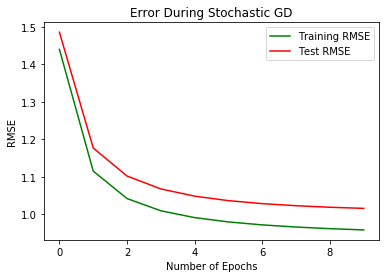

In [56]:
# provjeravanje performansi grafickim prikazom greske na skupu za obucavanje i testiranje
plt.plot(train_errors_per_epochs, color="g", label='Training RMSE')
plt.plot(test_errors_per_epochs, color="r", label='Test RMSE')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE')
plt.title('Error During Stochastic GD')
plt.legend()
# Tokom procesa obucavanja, greska na skupu za obucavanje ima trend opadanja

In [0]:
predicted_train=np.dot(P, Q.T)

In [58]:
print('SGD CF RMSE train: {}'.format(get_rmse(predicted_train, train)))
print('SGD CF MAE train: {}'.format(get_mae(predicted_train, train)))

SGD CF RMSE train: 0.9581424107325234
SGD CF MAE train: 0.7850325074735904


### Validacija na test skupu

In [0]:
f = 5  # broj parova latentnih faktora
lmbda = 0.5 # Regularisation strength
gamma=0.01  # Learning rate
n_epochs = 10  
P = np.sqrt(test.max())* np.random.rand(n_users, f) # Latentni faktori za korisnika
Q = np.sqrt(test.max())* np.random.rand(n_movies, f) 

In [0]:
# SGD na test skupu
users,items = test.nonzero()      
for epoch in range(n_epochs):
    for u, i in zip(users,items):
        e = test[u, i] - np.dot(P[u, :], Q[i, :].T)  
        P[u, :] += gamma * ( e * Q[i, :] - lmbda * P[u, :]) 
        Q[i, :] += gamma * ( e * P[u, :] - lmbda * Q[i, :]) 

In [0]:
predicted_test=np.dot(P, Q.T)

In [62]:
print('SGD CF RMSE test: {}'.format(get_rmse(predicted_test, test)))
print('SGD CF MAE test: {}'.format(get_mae(predicted_test, test)))

SGD CF RMSE test: 0.9319960606195212
SGD CF MAE test: 0.7580377235232063
